In [70]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr
from scipy.stats import spearmanr

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score

import joblib

import data_utilities as du
import model_utilities as mu

## Project Motivation
The year 2020 was defined by the novel coronavirus, COVID19, pandemic.  Countries around the world instituted various policies to protect their citizens and minimize contagion.  It would be useful to know which of those policies most impacted outcomes measured in cases or deaths, or if they impacted them at all. It would also be useful to know if uncontrollable factors like percent of population living in cities, population density, or the median age of the population had as much or more of an impact than active government interventions.

I would like to 1) understand the relationships between specific policies and outcomes, and 2) determine if there is any predictive capability of policies to outcome.

Oxford University publishes a dataset of government policy interventions with COVID19 cases and deaths daily per country. I added demographic data per country representing the uncontrollable factors. To gain an understanding of policy to outcome relationships, I will evaluate statistical correlations. To determine if there are predictive capabilities, I will use model feature selection and model training feature importances.

Based on the way that the novel coronavirus and its variants flow through a population and the attributes of people most impacted, you might start with these ideas:

* The stronger the actions taken by governments, the lower the contagion rate, as measured by confirmed cases, and the lower the casualty rate, as measured by deaths.  There should be some identifiable, measurable correlations between policies and outcomes.
* The strongest correlations might be inverse relationships between policies that restrict physical proximity such as school closings or limited private gatherings, thus minimizing ability to spread the disease, and outcomes.
* Uncontrollable factors like the percentage of population living closely together in urban environments or the median age of the population could have as much or more impact than active interventions.

In [2]:
filestring1 = 'DSND_covid19_policy_tracker.csv'
filestring2 = 'worldmeter_info2020.csv'
merge_field = 'country_name'
covid = pd.read_csv(filestring1)
demos = pd.read_csv(filestring2)
covid = pd.merge(covid, demos, how='inner', on=merge_field)
covid = covid.drop(columns=['Unnamed: 0'], axis=1)


/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104877 entries, 0 to 104876
Data columns (total 57 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   country_name                             104877 non-null  object 
 1   alpha_3_code                             104877 non-null  object 
 2   region_name                              37152 non-null   object 
 3   region_code                              37152 non-null   object 
 4   date                                     104877 non-null  object 
 5   school_closing                           102029 non-null  float64
 6   school_closing_flag                      78892 non-null   float64
 7   school_closing_notes                     4593 non-null    object 
 8   workplace_closing                        102023 non-null  float64
 9   workplace_closing_flag                   72813 non-null   float64
 10  workplace_closing_notes         

#### Document preprocessing data transformations

In [4]:
covid['country_name'].value_counts()

United States           20511
Brazil                  10836
Canada                   5418
United Kingdom           1935
Ethiopia                  387
                        ...  
United Arab Emirates      387
Sudan                     387
Zimbabwe                  387
Eritrea                   387
Faeroe Islands            387
Name: country_name, Length: 175, dtype: int64

Some countries, eg. the United States and Brazil, include regions in their tracking, vastly multiplying their datapoints. In comparison, China is tracked in total, with one datapoint per day.  Add a 'geo' column to increase analytic flexibility.

In [5]:
# Cleaning and filling
# drop all rows missing the target labels
covid = covid.dropna(subset=['deaths','confirmed_cases'], axis=0)
# drop all rows where target labels are zero
covid = covid.loc[(covid['confirmed_cases'] > 0.0) & (covid['deaths'] > 0.0)]
# drop all rows missing summary indicator
covid = covid.loc[covid['stringency_index'].notnull()]
# ensure date field is datetime to manipulate more easily
covid['date'] = pd.to_datetime(covid['date'])
# make regional data consistent: if NA, cumulative for the country
covid['region_name'] = covid['region_name'].fillna('Total')
# create a combined field to break up larger countries into regions
covid['geo'] = covid['country_name'] + covid['region_name']
# drop unused identifying columns
covid = covid.drop(['alpha_3_code','region_code'], axis=1)
# drop uncategorized policy columns
covid = covid.drop(['misc_wildcard','misc_wildcard_notes'], axis=1)
# prepare for change calcs
covid.sort_values(['geo', 'date'], ascending=True, 
                      inplace=True, na_position='last')
# subset the free text columns and drop them from main df
cols_notes = ['school_closing_notes','workplace_closing_notes',
             'cancel_public_events_notes','restrictions_on_gatherings_notes', 
             'stay_at_home_requirements_notes', 'restrictions_on_internal_movement_notes',
             'international_travel_controls_notes','income_support_notes',
             'debt_contract_relief_notes', 'fiscal_measures_notes', 
             'international_support_notes', 'public_information_campaigns_notes',
             'testing_policy_notes', 'contact_tracing_notes',
             'emergency_healthcare_investment_notes', 'vaccine_investment_notes']
covid_notes = covid[list(covid[cols_notes])]
covid = covid.drop(cols_notes, axis=1)



In [6]:
# normalize the raw statistics by population
covid['case_perc_pop'] = (covid['confirmed_cases'] / covid['population'])
covid['death_perc_pop'] = (covid['deaths'] / covid['population'])

In [7]:
# get the changes in target data over time
covid['case_perc_change'] = np.round(covid['confirmed_cases'].pct_change(), decimals=2)
covid['death_perc_change'] = np.round(covid['deaths'].pct_change(), decimals=2)
# remove calculation infinites
covid = covid.drop(covid.index[list(np.where(np.isfinite(covid['case_perc_change']) == False))])
covid = covid.drop(covid.index[list(np.where(np.isfinite(covid['death_perc_change']) == False))])

/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [8]:
# get whether outcomes are increasing (0) or decreasing (1)
covid['case_direction'] = covid['case_perc_change'].apply(lambda x: 0 if x <= 0 else 1)
covid['death_direction'] = covid['death_perc_change'].apply(lambda x: 0 if x <= 0 else 1)

#### At this point, the outcomes to be analyzed are available in four formats:
* original: absolute and cumulative, columns confirmed_cases and deaths
* relative to population: columns case_perc_pop, death_perc_pop
* change over time: columns case_perc_change, death_perc_change
* direction over time: columns case_direction, death_direction

In [9]:
cols_outcomes = ['confirmed_cases', 'deaths','case_perc_pop', 'death_perc_pop',
               'case_perc_change','death_perc_change','case_direction','death_direction']


In [10]:
# The true desired outcome is decreasing cases, a negative percent change
# How much of the dataset represents that case?
num_best_outcomes = len(covid.loc[covid['case_perc_change'] < 0])
print('Best outcomes: ', num_best_outcomes, num_best_outcomes/len(covid))
num_good_outcomes = len(covid.loc[covid['case_perc_change'] <= 0])
print('Good outcomes: ', num_good_outcomes, num_good_outcomes/len(covid))

Best outcomes:  324 0.0044276812069531
Good outcomes:  24426 0.33379796654640864


In [11]:
# the binary case direction has values 0 for stable or decreasing cases, 1 for increasing cases
covid['case_direction'].value_counts()

1    48750
0    24426
Name: case_direction, dtype: int64

In [12]:
# enhance the summary metric, the stringency_index
# get the change in stringency_index
covid['stringency_change'] = np.round(covid['stringency_index'].pct_change(), decimals=2)
# remove calculation infinites
covid = covid.drop(covid.index[list(np.where(np.isfinite(covid['stringency_change']) == False))])
# get the stringency direction, are governments tightening (1) or loosening/keeping (0) policy?
covid['stringency_direction'] = covid['stringency_change'].apply(lambda x: 0 if x <= 0 else 1)
# at this point, the summary metric is available in three formats
cols_stringency = ['stringency_index','stringency_change','stringency_direction']

/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexes/base.py:4114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [13]:
# do quick cleaning step to prevent calculation errors
if covid.isnull().sum().sum() > 0:
    covid = covid.fillna(value=0)

In [14]:
# How much does the summary metric, stringency index, vary?
covid['stringency_index'].value_counts()

64.81    1709
60.19    1407
84.26    1382
65.74    1314
62.96    1284
         ... 
21.76       1
98.15       1
26.39       1
18.06       1
88.43       1
Name: stringency_index, Length: 175, dtype: int64

In [15]:
# We can see that the stringency index varies significantly among countries, 
# but how often does the stringency index change once set by that government?
len(covid.loc[covid['stringency_change'] != 0])/len(covid)

0.058131270331592905

In [16]:
# monetary values are different scale from binary or ordinal rankings
cols_financial_amts = ['income_support', 'debt_contract_relief',
                    'fiscal_measures', 'international_support',
                    'emergency_healthcare_investment', 'vaccine_investment']

In [17]:
scaler = MinMaxScaler()
for col in cols_financial_amts:
    # scale the financial amounts to range [0..1]
    sc_colname = 'scaled_'+col
    covid[sc_colname] = scaler.fit_transform(covid[[col]])
    # get the binary for whether policy was active (>0 allocated) or not
    bi_colname = col+'_flag'
    covid[bi_colname] = covid[col].apply(lambda x: 0 if x <= 0 else 1)

In [19]:
# scale the demographic data
cols_demos = ['population', 'urban_perc', 'density', 'median_age']
for col in cols_demos:
    # scale the diverse units to range [0..1]
    scd_colname = 'scaled_'+col
    covid[scd_colname] = scaler.fit_transform(covid[[col]])

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73162 entries, 39278 to 103331
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   country_name                            73162 non-null  object        
 1   region_name                             73162 non-null  object        
 2   date                                    73162 non-null  datetime64[ns]
 3   school_closing                          73162 non-null  float64       
 4   school_closing_flag                     73162 non-null  float64       
 5   workplace_closing                       73162 non-null  float64       
 6   workplace_closing_flag                  73162 non-null  float64       
 7   cancel_public_events                    73162 non-null  float64       
 8   cancel_public_events_flag               73162 non-null  float64       
 9   restrictions_on_gatherings              73162

#### Correlation analysis one: Policies active or not
For the first test of correlation, let's look at the dataset flags for which policies were active, and compare them with whether cases were going up or down, using scipy.stats for Pearsons and Spearmans.
Correlation is the degree to which any two data points are related. For statistical analysis, the <a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html'>Pearson correlation coefficent</a> is the degree to which they are linearly related and is represented by a float between -1.0 and 1.0. The relationship is linear only when a change in one feature is associated with a proportional change in the other. A negative coefficient indicates an inverse relationship and a zero would be no relationship at all.  The Pandas corr function uses Pearson's calculation for correlation between numeric columns. (Note: I wrote my own function using scipy.stats for a slightly cleaner output.)
If you want a broader perspective, you can use scipy for <a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html'>Spearman's correlation</a>. The difference is that Spearman does not assume a constant, proportional rate of change, simply that there is a directional change.  Spearman captures monotonic relationships as well as linear relationships. Spearman is generally considered best for ranked data.

In [21]:
cols_binary = ['geo','country_name', 'region_name','date',
        'case_direction','death_direction',
        'stringency_direction',
       'school_closing_flag', 'workplace_closing_flag',
       'cancel_public_events_flag',
       'restrictions_on_gatherings_flag',
       'close_public_transit_flag',
       'stay_at_home_requirements_flag',
       'restrictions_on_internal_movement_flag',
       'international_travel_controls',
       'income_support_flag',
       'public_information_campaigns_flag',
       'testing_policy',
       'contact_tracing',
       'debt_contract_relief_flag',
       'fiscal_measures_flag',
       'international_support_flag',
       'emergency_healthcare_investment_flag',
       'vaccine_investment_flag']
covid_binary = covid[list(covid[cols_binary])]
covid_binary.shape

(73162, 24)

In [22]:
# get pearsons coefficient on binary policies and directional change in cases
cols_to_check = cols_binary[6:]
binary_corr = du.get_pearsons_corr(covid_binary, cols_to_check, 'case_direction')
impt_binaries = binary_corr.loc[(abs(binary_corr['corr']) > 0.10)]
impt_binaries.head()

,feature,corr
6,stay_at_home_requirements_flag,0.113356
7,restrictions_on_internal_movement_flag,0.148206
8,international_travel_controls,0.153325


In [23]:
# try spearmans to get directional relationships
spearman_corr = du.get_spearmans_corr(covid_binary, cols_to_check, 'case_direction')
impt_sc_bin = spearman_corr.loc[(abs(spearman_corr['corr']) > 0.10)]
impt_sc_bin.head()

,feature,corr
6,stay_at_home_requirements_flag,0.113356
7,restrictions_on_internal_movement_flag,0.148206
8,international_travel_controls,0.154078


In [24]:
cols_ordinal = ['geo','country_name', 'region_name','date',
                'case_perc_change','death_perc_change',
                'case_direction','death_direction',
                'stringency_index',
                'school_closing', 'workplace_closing',
                'cancel_public_events', 'restrictions_on_gatherings',
                'close_public_transit', 'stay_at_home_requirements',
                'restrictions_on_internal_movement',
                'international_travel_controls',
                'public_information_campaigns','testing_policy',
                'contact_tracing',
                'scaled_income_support', 'scaled_debt_contract_relief',
               'scaled_fiscal_measures','scaled_international_support',
               'scaled_emergency_healthcare_investment',
               'scaled_vaccine_investment',
                'scaled_population','scaled_density',
                'scaled_urban_perc','scaled_median_age'
               ]

In [25]:
covid_ordinal = covid[list(covid[cols_ordinal])]
covid_ordinal.shape

(73162, 30)

In [26]:
ords_to_check = cols_ordinal[8:]
pc_ordinal_corr = du.get_pearsons_corr(covid_ordinal, ords_to_check, 'case_direction')
impt_ordinals = pc_ordinal_corr.loc[(abs(pc_ordinal_corr['corr']) > 0.10)]
impt_ordinals.head()

,feature,corr
0,stringency_index,0.255634
1,school_closing,0.233636
2,workplace_closing,0.218994
3,cancel_public_events,0.176953
4,restrictions_on_gatherings,0.139392


In [27]:
# try spearmans to get directional relationships
sc_ordinal_corr = du.get_spearmans_corr(covid_ordinal, ords_to_check, 'case_direction')
impt_sc_ord = sc_ordinal_corr.loc[(abs(sc_ordinal_corr['corr']) > 0.10)]
impt_sc_ord.head()

,feature,corr
0,stringency_index,0.240886
1,school_closing,0.230886
2,workplace_closing,0.203726
3,cancel_public_events,0.160724
4,restrictions_on_gatherings,0.162954


#### Build data visualizations to demonstrate data explorations
Let's visualize some of the features showing correlations.

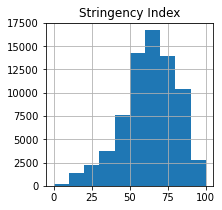

In [28]:
#covid['stringency_index'].hist()
fig, ax = plt.subplots(figsize=(3,3))
covid.hist('stringency_index', ax=ax)
ax.set_title('Stringency Index')
fig.savefig('stringency_index_hist_3x3.png', bbox_inches='tight')
plt.show()

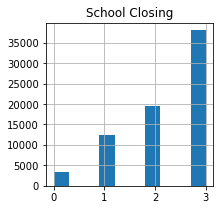

In [29]:
# covid['school_closing'].hist()
fig, ax = plt.subplots(figsize=(3,3))
covid.hist('school_closing', ax=ax)
ax.set_title('School Closing')
fig.savefig('school_closing_hist_3x3.png', bbox_inches='tight')
plt.show()

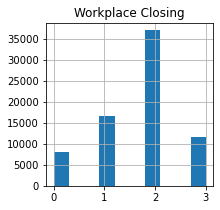

In [30]:
# covid['workplace_closing'].hist()
fig, ax = plt.subplots(figsize=(3,3))
covid.hist('workplace_closing', ax=ax)
ax.set_title('Workplace Closing')
fig.savefig('workplace_closing_hist_3x3.png', bbox_inches='tight')
plt.show()

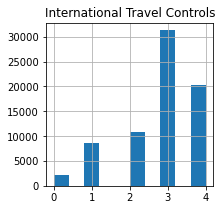

In [31]:
# covid['international_travel_controls'].hist()
fig, ax = plt.subplots(figsize=(3,3))
covid.hist('international_travel_controls', ax=ax)
ax.set_title('International Travel Controls')
fig.savefig('international_travel_contols_hist_3x3.png', bbox_inches='tight')
plt.show()

/Users/lquera/Dropbox/DSND/DSND_Project_Capstone/Quera_capstone_submission/data_utilities.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['date'] = pd.to_datetime(comp_df['date'])


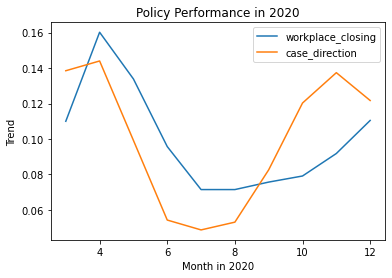

<Figure size 432x288 with 0 Axes>

In [32]:
du.compare_policy_outcomes(covid, 'Canada', 'workplace_closing', 'case_direction')

In [33]:
cols_demos = ['geo','country_name', 'region_name','date',
                'case_perc_pop','death_perc_pop',
                'urban_perc', 'median_age','density'
               ]

In [34]:
covid_demos = covid[list(covid[cols_demos])]
covid_demos.shape

(73162, 9)

In [35]:
# just to validate the use of scatter plot rather than scipy corrs
demos_to_check = cols_demos[6:]
pc_demos_corr = du.get_pearsons_corr(covid_demos, demos_to_check, 'case_perc_pop')
impt_demos = pc_demos_corr.loc[(abs(pc_demos_corr['corr']) > 0.10)]
impt_demos.head()

,feature,corr


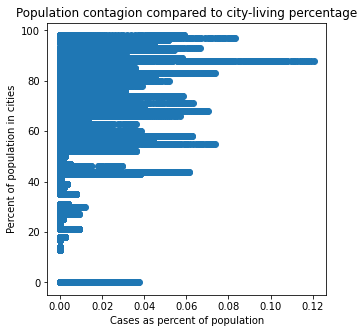

In [36]:
#pd.plotting.scatter_matrix(covid_demos[['case_perc_pop','urban_perc']], figsize=(15,15))

plt.scatter(covid_demos['case_perc_pop'], covid_demos['urban_perc'])
plt.xlabel('Cases as percent of population')
plt.ylabel('Percent of population in cities')
plt.title('Population contagion compared to city-living percentage')
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.savefig('case_perc_pop_and_urban_perc_5x5.png')
plt.show()

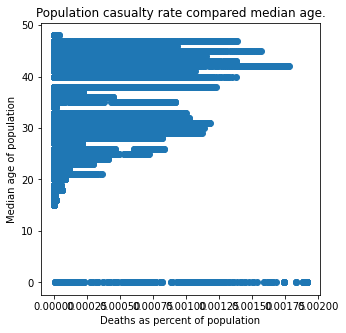

In [37]:
plt.scatter(covid_demos['death_perc_pop'], covid_demos['median_age'])
plt.xlabel('Deaths as percent of population')
plt.ylabel('Median age of population')
plt.title('Population casualty rate compared median age.')
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.savefig('death_perc_pop_and_median_age_5x5.png')
plt.show()

## Modeling for feature understanding

Another approach to understanding policies and outcomes, is to use models to identify which features improve predictive capability. Let's look at feature selection and feature importance.

Feature selection is the process of testing the relationships between each training feature and the target feature and selecting the ones with the strongest relationship. It shows the impact of the variable on the model success metric and the higher it is, the more valuable the feature's predictive capability. Negative feature importance means that the feature increases the loss and either the model is underfitting or the model would benefit from removing the feature.

SelectKBest is a univariate method that uses statistical means to evaluate the relationships and keeps the K highest-scoring features. RFE (Recursive Feature Elimination) fits a model on all features and then recursively eliminates the one with the lowest importance score until it gets to the K highest scoring features.

You can use feature selection in your model training process and then access the feature_importance_ attribute to visualize which features impacted the model most.  I chose Random Forests (an ensemble of bagged Decision Trees) because the random splits create better tree diversity with less overfitting than simple Decision Trees. The feature importances are weighted averages of how much the feature reduces impurities across all trees in the forest.

First, let’s look at using SelectKBest feature selection for a RandomForestRegressor optimized for the Mean Absolute Error.

A note on metrics: MAE, mean absolute error, is best suited to the task at hand because my goal is interpretability, teasing out the underlying relationships of policies and outcomes.  MAE is considered superior for interpretability because it simply describes average errors and is not as impacted by test sample size.  The downside is the significantly larger computation time. (“When the random forest regressor optimizes for MSE it optimizes for the L2-norm and a mean-based impurity metric. But when the regressor uses the MAE criterion it optimizes for the L1-norm which amounts to calculating the median.”[https://stackoverflow.com/questions/57243267/why-is-training-a-random-forest-regressor-with-mae-criterion-so-slow-compared-to])

In [42]:
# Define training data parameters
model_data = covid
train_cols = cols_ordinal[8:]
target = 'case_perc_change'
# Feature Selection
n_features = 12
selection = 'stat'
problem_type = 'regression'
scoring = 'f_regression'
# Data Splitting
test_size = 0.30
random_state = 17
# RandomForest
n_estimators = 100
criterion = 'mae'

In [43]:
X_train, X_test, y_train, y_test, stat_features_used = mu.get_train_test_data(
            model_data, train_cols, target,
            problem_type=problem_type,
            scoring=scoring,
            n_features=n_features,
            selection=selection,
            test_size=test_size)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(51213, 12) (51213,) (21949, 12) (21949,)


/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [44]:
rfstat = RandomForestRegressor(n_estimators=n_estimators,
                           criterion=criterion,
                           random_state=random_state,
                           n_jobs=-1)
rfstat, rfstat_results = mu.train_and_score_model(rfstat, X_train, y_train, X_test, y_test, problem_type,
                                       'RandomForestRegressor')

RandomForestRegressor
R2 train: 0.257, test: -0.000
MSE train: 0.008, test: 0.015
MAE train: 0.020, test: 0.022


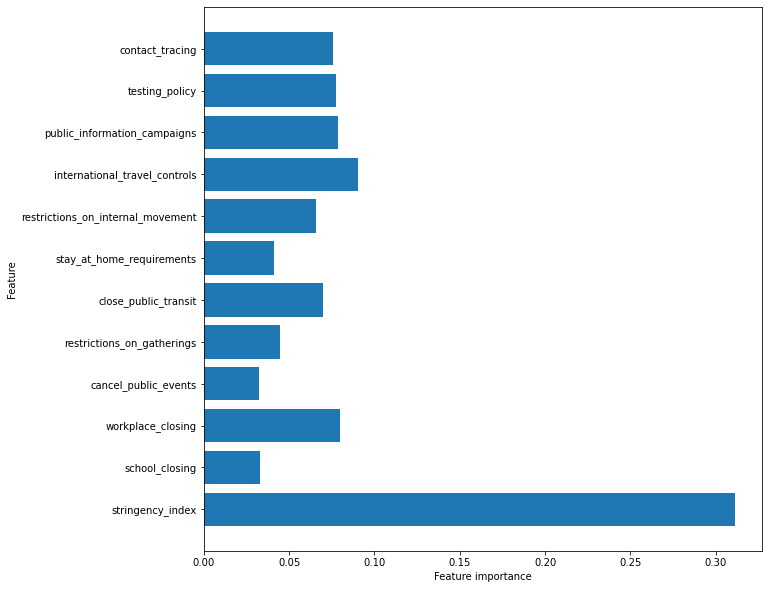

In [45]:
mu.visualize_feature_importance(rfstat, X_train, stat_features_used, 'RF_reg_stat_ordinals_10x10.png', selection, 'tree')

In [ ]:
len(covid.loc[abs(covid['case_perc_change']) < 0.04])/len(covid)

In [47]:
rfstat_cross_vals = cross_val_score(rfstat, X_train, y_train, cv=3)
rfstat_cross_vals

array([-0.02653215,  0.00137319,  0.02343883])

#### Does Recursive Feature Elimination return different features?
Next, let’s look at using Recursive Feature Elimination feature selection for a RandomForestRegressor optimized for the Mean Absolute Error

In [49]:
# Define training data parameters
model_data = covid
train_cols = cols_ordinal[8:]
target = 'case_perc_change'
# Feature Selection
n_features = 12
selection = 'RFE'
problem_type = 'regression'
scoring = 'f_regression'
# Data Splitting
test_size = 0.30
random_state = 17
# RandomForest
n_estimators = 30
criterion = 'mae'

In [50]:
X_train, X_test, y_train, y_test, rfe_features_used = mu.get_train_test_data(
            model_data, train_cols, target,
            problem_type=problem_type,
            scoring=scoring,
            n_features=n_features,
            selection=selection,
            test_size=test_size)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


[11  2  1  5  6  8  7  9  1 10  1  4  1  1  1  1  1  3  1  1  1  1]
(51213, 12) (51213,) (21949, 12) (21949,)


In [51]:
rfrfe = RandomForestRegressor(n_estimators=n_estimators,
                           criterion=criterion,
                           random_state=random_state,
                           n_jobs=-1)
rfrfe, rfrfe_results = mu.train_and_score_model(rfrfe, X_train, y_train, X_test, y_test, problem_type,
                                       'RandomForestRegressor')

RandomForestRegressor
R2 train: 0.179, test: 0.014
MSE train: 0.009, test: 0.015
MAE train: 0.021, test: 0.022


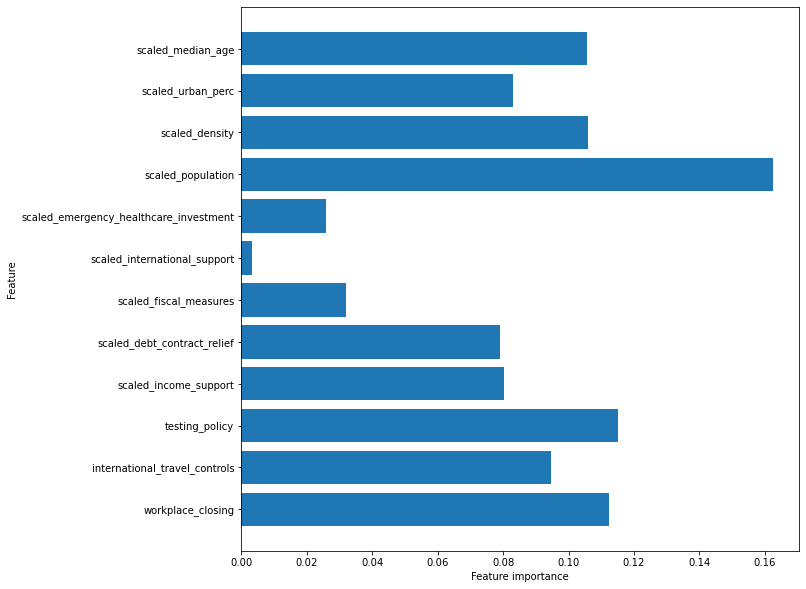

In [53]:
mu.visualize_feature_importance(rfrfe, X_train, rfe_features_used, 'RF_reg_RFE_ordinals_10x10.png', selection, 'tree')

### Reframe as binary classification problem
Lastly, since we calculated the directional change of the outcomes, we can reformulate the problem to a binary classification - cases up or cases down. Let’s see if that makes anything clearer using SelectKBest feature selection for a RandomForestClassifier optimized for information gain, ie. entropy.

In [54]:
# Define training data parameters
model_data = covid
train_cols = cols_ordinal[8:]
target = 'case_direction'
# Feature Selection
n_features = 12
selection = 'stat'
problem_type = 'classification'
scoring = 'mutual_info_classif'
# Data Splitting
test_size = 0.30
random_state = 17
# RandomForest
n_estimators = 500
criterion = 'entropy'

In [55]:
X_train, X_test, y_train, y_test, rfc_features_used = mu.get_train_test_data(
            model_data, train_cols, target,
            problem_type=problem_type,
            scoring=scoring,
            n_features=n_features,
            selection=selection,
            test_size=test_size)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(51213, 12) (51213,) (21949, 12) (21949,)


In [56]:
rfc = RandomForestClassifier(n_estimators=n_estimators,
                           criterion=criterion,
                           random_state=random_state,
                           n_jobs=-1)
rfc, rfc_results = mu.train_and_score_model(rfc, X_train, y_train, X_test, y_test, problem_type,
                                       'RandomForestClassifier')

RandomForestClassifier
Accuracy train: 0.859, test: 0.838
Precision train: 0.880, test: 0.862
Recall train: 0.913, test: 0.899


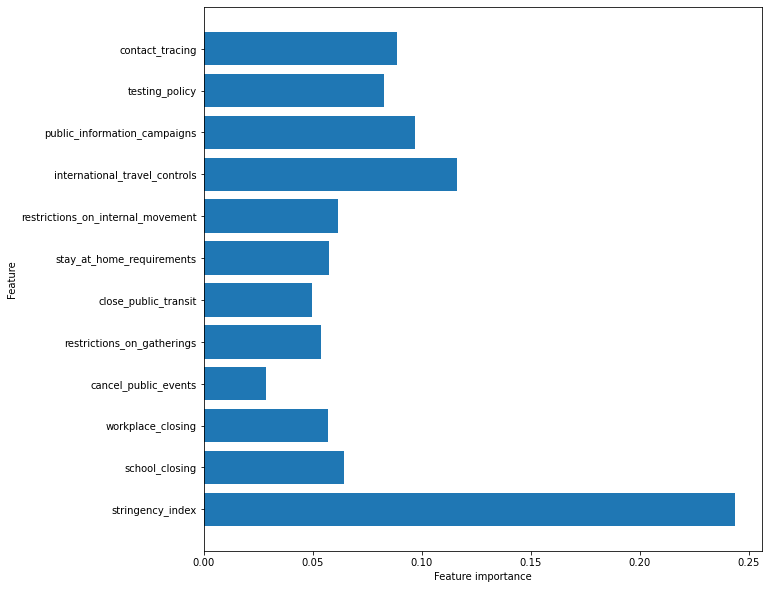

In [57]:
mu.visualize_feature_importance(rfc, X_train, rfc_features_used, 
                                'RFC_stat_ordinals_10x10.png', selection, 'tree')

In [58]:
rfc_cross_vals = cross_val_score(rfc, X_train, y_train, cv=3, scoring='precision')
rfc_cross_vals

array([0.87018861, 0.86453474, 0.8662678 ])

In [59]:
# Define training data parameters
model_data = covid
train_cols = cols_ordinal[8:]
target = 'case_direction'
# Feature Selection
n_features = 12
selection = 'RFE'
problem_type = 'classification'
scoring = 'mutual_info_classif'
# Data Splitting
test_size = 0.30
random_state = 17
# RandomForest
n_estimators = 500
criterion = 'entropy'

In [60]:
X_train, X_test, y_train, y_test, rfcrfe_features_used = mu.get_train_test_data(
            model_data, train_cols, target,
            problem_type=problem_type,
            scoring=scoring,
            n_features=n_features,
            selection=selection,
            test_size=test_size)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


[ 1  1  3  6  1  4  2  1  1  9  1  1  1  5  7 10  8 11  1  1  1  1]
(51213, 12) (51213,) (21949, 12) (21949,)


In [61]:
rfcrfe = RandomForestClassifier(n_estimators=n_estimators,
                           criterion=criterion,
                           random_state=random_state,
                           n_jobs=-1)
rfcrfe, rfcrfe_results = mu.train_and_score_model(rfcrfe, X_train, y_train, X_test, y_test, problem_type,
                                       'RandomForestClassifier')

RandomForestClassifier
Accuracy train: 0.865, test: 0.841
Precision train: 0.885, test: 0.865
Recall train: 0.917, test: 0.901


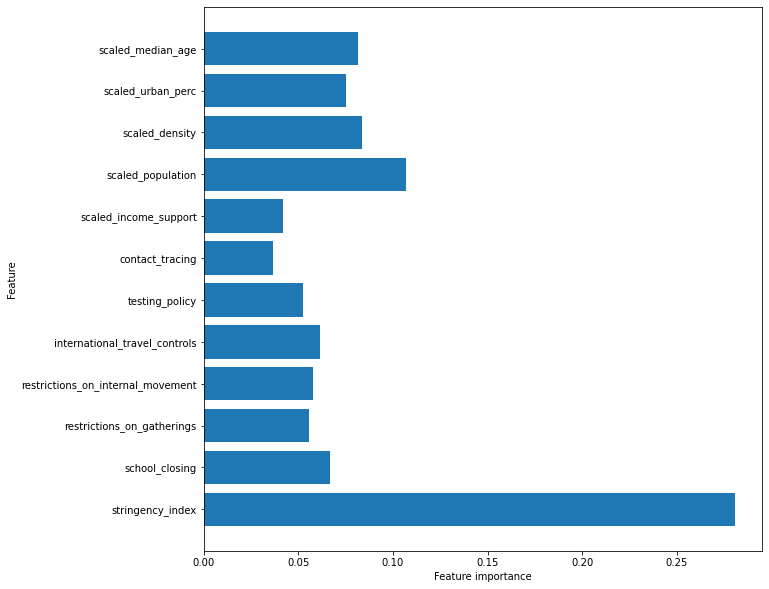

In [62]:
mu.visualize_feature_importance(rfcrfe, X_train, rfcrfe_features_used, 
                                'RFC_RFE_ordinals_10x10.png', selection, 'tree')

In [63]:
rfcrfe_cross_vals = cross_val_score(rfcrfe, X_train, y_train, cv=3, scoring='precision')
rfcrfe_cross_vals

array([0.87447375, 0.86886366, 0.87052062])

In [64]:
# Define training data parameters
model_data = covid
train_cols = cols_binary[6:]
target = 'case_direction'
# Feature Selection
n_features = 12
selection = 'stat'
problem_type = 'classification'
scoring = 'mutual_info_classif'
# Data Splitting
test_size = 0.30
random_state = 17
# RandomForest
n_estimators = 500
criterion = 'entropy'

In [65]:
X_train, X_test, y_train, y_test, rfcb_features_used = mu.get_train_test_data(
            model_data, train_cols, target,
            problem_type=problem_type,
            scoring=scoring,
            n_features=n_features,
            selection=selection,
            test_size=test_size)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/lquera/opt/anaconda3/envs/DSND/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(51213, 12) (51213,) (21949, 12) (21949,)


In [66]:
rfcb = RandomForestClassifier(n_estimators=n_estimators,
                           criterion=criterion,
                           random_state=random_state,
                           n_jobs=-1)
rfcb, rfcb_results = mu.train_and_score_model(rfcb, X_train, y_train, X_test, y_test, problem_type,
                                       'RandomForestClassifier')

RandomForestClassifier
Accuracy train: 0.773, test: 0.760
Precision train: 0.797, test: 0.786
Recall train: 0.886, test: 0.878


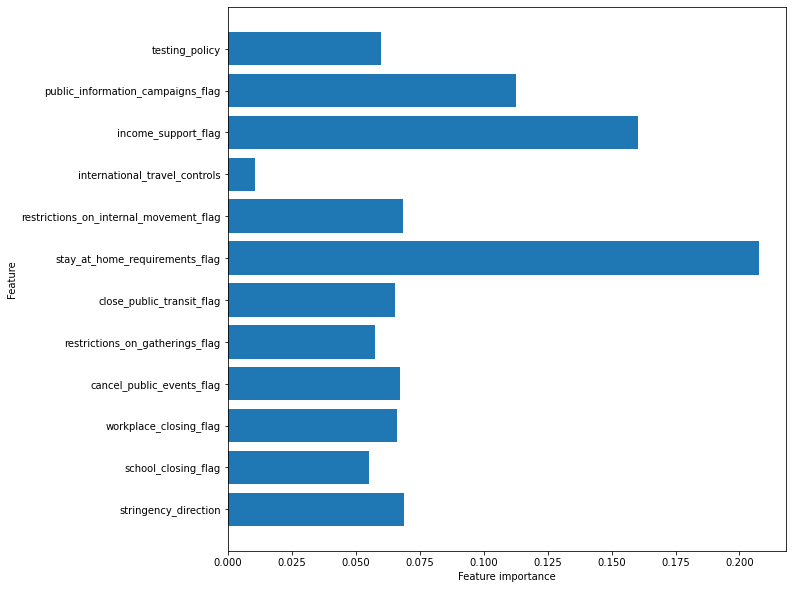

In [67]:
mu.visualize_feature_importance(rfcb, X_train, rfcb_features_used, 
                                'RFC_stat_binary_10x10.png', selection, 'tree')

In [68]:
rfcb_cross_vals = cross_val_score(rfcb, X_train, y_train, cv=3, scoring='precision')
rfcb_cross_vals

array([0.79431479, 0.78907914, 0.79597608])

In [71]:
joblib.dump(rfc, 'RFC_stat_ord.joblib')

['RFC_stat_ord.joblib']

### Model evaluation and validation
Classification is much better suited to our problem and dataset. The goal is not to predict a precise number on a continuum, but to understand what impacts the desirable outcome, stable/negative case direction.  This aligns nicely with binary classification and you can see that alignment in the results.  The regression metric MAE was large, signifying an inability to reliably predict the outcome.  The classification metric, Precision, was high, signifying a good ability to predict the desirable outcome.  Precision was also very stable in cross-validation.

## Conclusions
Now that we've analyzed the data and run it through some models, what do we know about our original hypotheses?

* The correlations between policies and outcomes are much weaker than hoped for.
* The strongest of the admittedly weak correlations are indeed the proximity-impacting policies such as stay at home requirements, school closings, workplace closing, restrictions on travel, etc.  This aligns with a logical understanding of how the disease spreads.
* Government capabilities are indeed bounded by uncontrollable factors like urban percentages and median age. This aligns with known data, that is, that proximity is a key factor in contagion and older citizens will die at higher rates than younger ones.

While the data did support the initial logic, the correlation coefficients are too small to enable strong recommendations for any specific policy. This is disappointing but perhaps as more data accumulates, better correlations will emerge and we will be more prepared for the next aerosol/droplet contagious disease.

## Technical Lessons Learned

I started with an idea: data on government policies and disease outcomes might help identify which policies are most impactful.  I gathered data from multiple sources, did the necessary cleaning and transformations, and used statistical analysis to identify correlations. Then I used feature selection and Random Forest models to identify predictive features. Lastly, I evaluated the original hypotheses against the accumulated data.

1) Why did some techniques work better? Classification worked much better than regression for this problem/dataset.  The binary nature of desirable outcome and primary goal of interpretability aligned well with classification.

2) What was the most difficult part? The two most difficult parts were 1) determining which data transformations would be most useful, and 2) determining which input variations, ie. binary flags vs ordinal policy intensities, would align best with which outcome variations, ie. changes in amounts vs changes in direction.  I tried to use as much logic as possible but there was a lot of trial and error involved.

3) What is one thing that could be improved? To improve the process, you could do more class and input balancing. For example, the inputs were weighted towards countries that tracked regions, such as the United States and Brazil. You could try taking only the totals for those countries and dropping the regions as potentially noise. (I kept them in to maximize number of datapoints available but more is not necessarily always better.) And for the classification model, the outcomes were unfortunately imbalanced towards increases in cases rather than the desired decreases. You could experiment with giving up half of the datapoints in that class but my concern was making the dataset too small.